# Legacy Notebook: 01_initial_exploration.ipynb

**Purpose**:  
This notebook is an **early exploration and debugging record** for our UCSD Course Evaluate project. It contains multiple iterations of parsing, cleaning, and computing GPA from the “Grade distribution” column, including attempts to handle issues like:
- Non-traditional letters (P, NP, W, etc.)
- “Grade Distribution is not available...” rows
- The `NaN != None` problem that caused 100% computable rows

**What’s in here**:
1. Various helper functions and half-finished parse logic.  
2. Step-by-step debugging cells (e.g., scanning unique letters, checking how many rows contain “not available,” etc.).  
3. Attempts that led to the final solution of using `pd.notna()` for `NaN` detection.

**Final Implementation**:  
A **clean, consolidated version** of the final data-cleaning approach is in  
[**`01_phase1_data_cleaning.ipynb`**](./01_phase1_data_cleaning.ipynb).  
That notebook is the recommended reference for how we currently import, parse, and classify GPA data.

> **Note**: This `01_initial_exploration.ipynb` file remains a historical artifact, kept for reference to show how the solution evolved. It is **not** intended for ongoing production use.

In [2]:
# ---
# Jupyter Notebook: 01_initial_exploration.ipynb
# Purpose: Initial CSV data reading and exploratory analysis
# ---

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
# For inline plots in Jupyter

In [4]:
# 1. Set the path to the CSV file
data_file = os.path.join("..", "data", "Crowd-sourced grade distributions - Sheet1.csv")

# 2. Read the CSV file into a DataFrame
df = pd.read_csv(data_file)

In [5]:
print("Preview of the dataset:")
df.head()

Preview of the dataset:


,Submission time,User ID,Term,Course,Professor,Grade distribution,Recommend professor?
0,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 120,"Voelker, Geoffrey M.","A+:11, A:41, A-:25, B+:41, B:28, B-:16, C+:12,...",NaN
1,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 132A,"Vianu, Victor Dan","A+:4, A:23, A-:19, B+:40, B:15, B-:27, C+:15, ...",NaN
2,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 141L,"Eldon, John","A+:1, A:28, A-:4, B+:2, B:0, B-:3, C+:0, C:3, ...",NaN
3,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 167,"Li, Tzumao","A+:102, A:22, A-:11, B+:5, B:7, B-:6, C+:2, C:...",NaN
4,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 230,"Jhala, Ranjit","A+:29, A:42, A-:26, B+:16, B:7, B-:1, C+:0, C:...",NaN


In [6]:
print("\nDataFrame info:")
df.info()

print("\nDescriptive statistics:")
df.describe()


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9454 entries, 0 to 9453
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Submission time       9454 non-null   object 
 1   User ID               9454 non-null   object 
 2   Term                  9454 non-null   object 
 3   Course                9454 non-null   object 
 4   Professor             9454 non-null   object 
 5   Grade distribution    9454 non-null   object 
 6   Recommend professor?  0 non-null      float64
dtypes: float64(1), object(6)
memory usage: 517.1+ KB

Descriptive statistics:


,Recommend professor?
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [7]:
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


Submission time            0
User ID                    0
Term                       0
Course                     0
Professor                  0
Grade distribution         0
Recommend professor?    9454
dtype: int64

In [8]:
all_grade_letters = set()

# Drop missing values to avoid errors in splitting
grade_distributions = df["Grade distribution"].dropna()

for dist_str in grade_distributions:
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter, count_str = letter_count
            letter = letter.strip()
            all_grade_letters.add(letter)

print("Unique grade letters found in the dataset:")
print(all_grade_letters)

Unique grade letters found in the dataset:
{'S', 'Class GPA', 'Blank', 'U', 'B+', 'A', 'A-', 'C', 'F', 'D', 'P', 'Total Students', 'IP', 'B-', 'C+', 'NP', 'B', 'W', 'I', 'Grade Distribution is not available for classes with 10 students or less.', 'C-', 'A+'}


In [9]:
# Mapping from letter grades to numeric GPA points (example scale)
grade_points_map = {
    "A+": 4.0, "A": 4.0, "A-": 3.7,
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0, "D-": 0.7,
    "F": 0.0
}

def parse_grade_distribution(dist_str):
    """
    dist_str example: "A+:11, A:41, A-:25, B+:41, ..."
    Returns a dict of the form { 'A+': 11, 'A': 41, 'A-': 25, ... }
    """
    grades = {}
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter, count_str = letter_count
            letter = letter.strip()
            try:
                count = int(count_str.strip())
            except ValueError:
                count = 0
            grades[letter] = count
    return grades

def compute_average_gpa(grades_dict):
    """
    Given a dict like { 'A+': 11, 'A': 41, 'A-': 25, ... },
    compute a weighted average GPA using grade_points_map.
    """
    total_students = 0
    total_points = 0.0
    for letter, cnt in grades_dict.items():
        if letter in grade_points_map:
            total_students += cnt
            total_points += cnt * grade_points_map[letter]
    if total_students == 0:
        return None
    return total_points / total_students

df["grade_dict"] = df["Grade distribution"].astype(str).apply(parse_grade_distribution)
df["calculated_gpa"] = df["grade_dict"].apply(compute_average_gpa)

print("Finished parsing 'Grade distribution' into 'grade_dict' and 'calculated_gpa'.")

Finished parsing 'Grade distribution' into 'grade_dict' and 'calculated_gpa'.



Plotting the calculated GPA distribution...


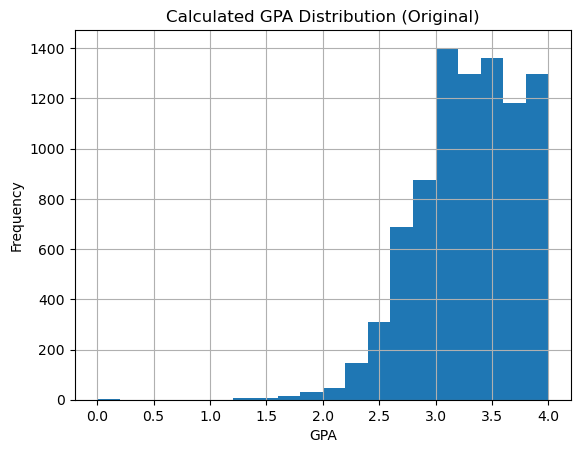

In [10]:
if "calculated_gpa" in df.columns:
    print("\nPlotting the calculated GPA distribution...")
    df["calculated_gpa"].hist(bins=20)
    plt.title("Calculated GPA Distribution (Original)")
    plt.xlabel("GPA")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
# 1. Define the set of "standard" letter grades that count toward GPA
standard_letters = set(grade_points_map.keys())  # e.g. {"A+", "A", "A-", "B+", "B", ...}

# 2. Define a helper function to check if a row's grade_dict has at least one standard letter
def has_standard_grade(grade_dict):
    for letter, count in grade_dict.items():
        if letter in standard_letters and count > 0:
            return True
    return False

df["has_standard_grade"] = df["grade_dict"].apply(has_standard_grade)

# 3. Calculate basic statistics
total_rows = len(df)
rows_with_standard = df["has_standard_grade"].sum()  # True is treated as 1
rows_only_non_traditional = total_rows - rows_with_standard
perc_with_standard = (rows_with_standard / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Rows with at least one standard letter grade: {rows_with_standard}")
print(f"Rows with only non-traditional letters: {rows_only_non_traditional}")
print(f"Percentage of rows with standard letter grades: {perc_with_standard:.2f}%")

Total rows: 9454
Rows with at least one standard letter grade: 8663
Rows with only non-traditional letters: 791
Percentage of rows with standard letter grades: 91.63%


In [12]:
# This cell is the intermediate attempt at "enhanced" parsing
# We keep it here for completeness, though we discovered a NaN vs None issue.

grade_points_map_lower = {
    "a+": 4.0, "a": 4.0, "a-": 3.7,
    "b+": 3.3, "b": 3.0, "b-": 2.7,
    "c+": 2.3, "c": 2.0, "c-": 1.7,
    "d+": 1.3, "d": 1.0, "d-": 0.7,
    "f": 0.0
}

skip_letters = {
    "class gpa", "total students", "blank",
    "p", "np", "s", "u", "w", "i", "ip"
}

def parse_grade_distribution_enhanced(dist_str):
    dist_str_lower = dist_str.lower()
    if "not available" in dist_str_lower:
        return {}
    grades = {}
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter_raw, count_str = letter_count
            letter_lower = letter_raw.strip().lower()
            if letter_lower in skip_letters:
                continue
            try:
                count = int(count_str.strip())
            except ValueError:
                count = 0
            if letter_lower in grade_points_map_lower:
                grades[letter_lower] = grades.get(letter_lower, 0) + count
    return grades

def compute_average_gpa_enhanced(grades_dict):
    total_students = 0
    total_points = 0.0
    for letter_lower, cnt in grades_dict.items():
        if letter_lower in grade_points_map_lower:
            total_students += cnt
            total_points += cnt * grade_points_map_lower[letter_lower]
    if total_students == 0:
        return None
    return total_points / total_students

df["enhanced_grade_dict"] = df["Grade distribution"].astype(str).apply(parse_grade_distribution_enhanced)
df["enhanced_calculated_gpa"] = df["enhanced_grade_dict"].apply(compute_average_gpa_enhanced)

def classify_gpa_status(gpa_value):
    return "computable" if gpa_value is not None else "noncomputable"  # This leads to NaN != None bug

df["gpa_status"] = df["enhanced_calculated_gpa"].apply(classify_gpa_status)

total_rows = len(df)
computable_rows = (df["gpa_status"] == "computable").sum()
noncomputable_rows = (df["gpa_status"] == "noncomputable").sum()

print(f"Total rows: {total_rows}")
print(f"Computable rows: {computable_rows}")
print(f"Noncomputable rows (only non-traditional or no data): {noncomputable_rows}")
print(f"Percentage of computable rows: {computable_rows / total_rows * 100:.2f}%")
print("\n(We discovered the 'NaN != None' issue here, so let's fix that in the next cell.)")

Total rows: 9454
Computable rows: 9454
Noncomputable rows (only non-traditional or no data): 0
Percentage of computable rows: 100.00%

(We discovered the 'NaN != None' issue here, so let's fix that in the next cell.)


In [13]:
print("=== 1) Check all column names ===")
print(df.columns.tolist())

print("\n=== 2) Check how many rows contain 'not available' in 'Grade distribution' (case-insensitive) ===")
df_not_avail = df[df["Grade distribution"].str.lower().str.contains("not available", na=False)]
print("Number of rows that contain 'not available':", len(df_not_avail))

print("\nSample rows that contain 'not available':")
display(df_not_avail[["Grade distribution"]].head(10))

print("\n=== 3) Let's see what enhanced_grade_dict and gpa_status look like for these rows ===")
display(df_not_avail[["enhanced_grade_dict", "enhanced_calculated_gpa", "gpa_status"]].head(10))

print("\n=== 4) Manually call the parse function on one example row ===")
if not df_not_avail.empty:
    example_str = df_not_avail.iloc[0]["Grade distribution"]
    print("Example 'Grade distribution' text:")
    print(example_str)
    print("\nparse_grade_distribution_enhanced(example_str) returns:")
    result_dict = parse_grade_distribution_enhanced(example_str)
    print(result_dict)
    
    print("\nIf parse_grade_distribution_enhanced() returns an empty dict, we expect a None GPA.")
    test_gpa = compute_average_gpa_enhanced(result_dict)
    print("Computed GPA on that dict:", test_gpa)
else:
    print("No rows found with 'not available'.")

=== 1) Check all column names ===
['Submission time', 'User ID', 'Term', 'Course', 'Professor', 'Grade distribution', 'Recommend professor?', 'grade_dict', 'calculated_gpa', 'has_standard_grade', 'enhanced_grade_dict', 'enhanced_calculated_gpa', 'gpa_status']

=== 2) Check how many rows contain 'not available' in 'Grade distribution' (case-insensitive) ===
Number of rows that contain 'not available': 280

Sample rows that contain 'not available':


,Grade distribution
67,Grade Distribution is not available for classe...
116,Grade Distribution is not available for classe...
119,Grade Distribution is not available for classe...
232,Grade Distribution is not available for classe...
237,Grade Distribution is not available for classe...
242,Grade Distribution is not available for classe...
250,Grade Distribution is not available for classe...
251,Grade Distribution is not available for classe...
252,Grade Distribution is not available for classe...
258,Grade Distribution is not available for classe...



=== 3) Let's see what enhanced_grade_dict and gpa_status look like for these rows ===


,enhanced_grade_dict,enhanced_calculated_gpa,gpa_status
67,{},NaN,computable
116,{},NaN,computable
119,{},NaN,computable
232,{},NaN,computable
237,{},NaN,computable
242,{},NaN,computable
250,{},NaN,computable
251,{},NaN,computable
252,{},NaN,computable
258,{},NaN,computable



=== 4) Manually call the parse function on one example row ===
Example 'Grade distribution' text:
Grade Distribution is not available for classes with 10 students or less.:null

parse_grade_distribution_enhanced(example_str) returns:
{}

If parse_grade_distribution_enhanced() returns an empty dict, we expect a None GPA.
Computed GPA on that dict: None


In [14]:
import pandas as pd

# Redefine or overwrite the same logic with a new cell,
# so the DataFrame updates with the correct classification.

grade_points_map_lower = {
    "a+": 4.0, "a": 4.0, "a-": 3.7,
    "b+": 3.3, "b": 3.0, "b-": 2.7,
    "c+": 2.3, "c": 2.0, "c-": 1.7,
    "d+": 1.3, "d": 1.0, "d-": 0.7,
    "f": 0.0
}

skip_letters = {
    "class gpa", "total students", "blank",
    "p", "np", "s", "u", "w", "i", "ip"
}

def parse_grade_distribution_enhanced(dist_str):
    dist_str_lower = dist_str.lower()
    if "not available" in dist_str_lower:
        return {}
    grades = {}
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter_raw, count_str = letter_count
            letter_lower = letter_raw.strip().lower()
            if letter_lower in skip_letters:
                continue
            try:
                count = int(count_str.strip())
            except ValueError:
                count = 0
            if letter_lower in grade_points_map_lower:
                grades[letter_lower] = grades.get(letter_lower, 0) + count
    return grades

def compute_average_gpa_enhanced(grades_dict):
    total_students = 0
    total_points = 0.0
    for letter_lower, cnt in grades_dict.items():
        if letter_lower in grade_points_map_lower:
            total_students += cnt
            total_points += cnt * grade_points_map_lower[letter_lower]
    if total_students == 0:
        return None
    return total_points / total_students

# Recalculate
df["enhanced_grade_dict"] = df["Grade distribution"].astype(str).apply(parse_grade_distribution_enhanced)
df["enhanced_calculated_gpa"] = df["enhanced_grade_dict"].apply(compute_average_gpa_enhanced)

# Use pd.notna() instead of None check
def classify_gpa_status(gpa_value):
    return "computable" if pd.notna(gpa_value) else "noncomputable"

df["gpa_status"] = df["enhanced_calculated_gpa"].apply(classify_gpa_status)

# Print summary again
total_rows = len(df)
computable_rows = (df["gpa_status"] == "computable").sum()
noncomputable_rows = (df["gpa_status"] == "noncomputable").sum()

print(f"Total rows: {total_rows}")
print(f"Computable rows: {computable_rows}")
print(f"Noncomputable rows (only non-traditional or no data): {noncomputable_rows}")
print(f"Percentage of computable rows: {computable_rows / total_rows * 100:.2f}%")

print("\nWith the pd.notna() fix, rows returning None->NaN should be 'noncomputable' now.")

Total rows: 9454
Computable rows: 8664
Noncomputable rows (only non-traditional or no data): 790
Percentage of computable rows: 91.64%

With the pd.notna() fix, rows returning None->NaN should be 'noncomputable' now.
